In [119]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

# Количество предсказанных дней
pred_days_forecast = 180

In [120]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [121]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

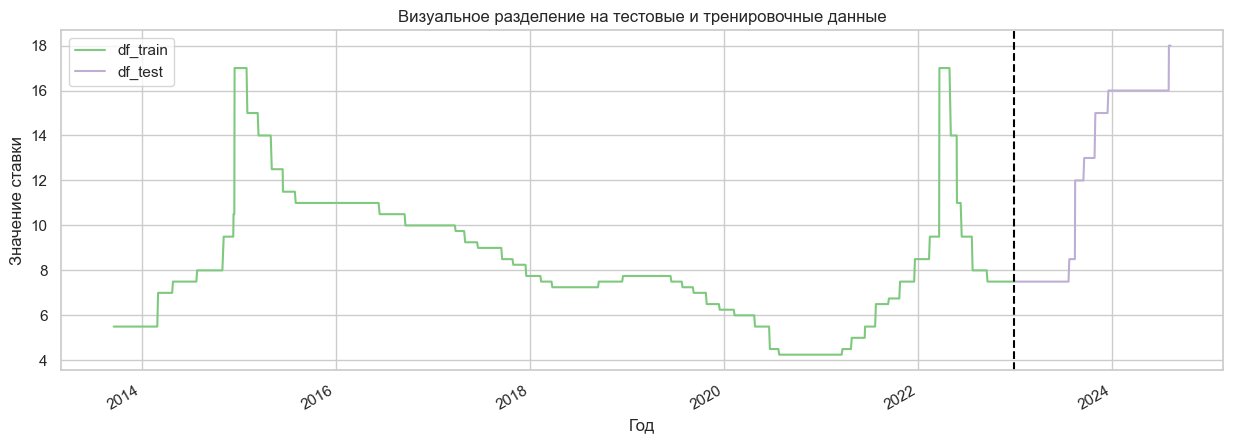

In [122]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

# Baseline Prophet on df_train для проверки модели

In [123]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

02:33:23 - cmdstanpy - INFO - Chain [1] start processing
02:33:23 - cmdstanpy - INFO - Chain [1] done processing


In [124]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.15)

In [125]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2712,2024-02-05,14.713849,12.419302,16.994909
2713,2024-02-06,14.743233,12.633034,17.136405
2714,2024-02-07,14.756209,12.528201,17.215720
2715,2024-02-08,14.736290,12.583177,16.960442
2716,2024-02-09,14.742578,12.603687,17.041193


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




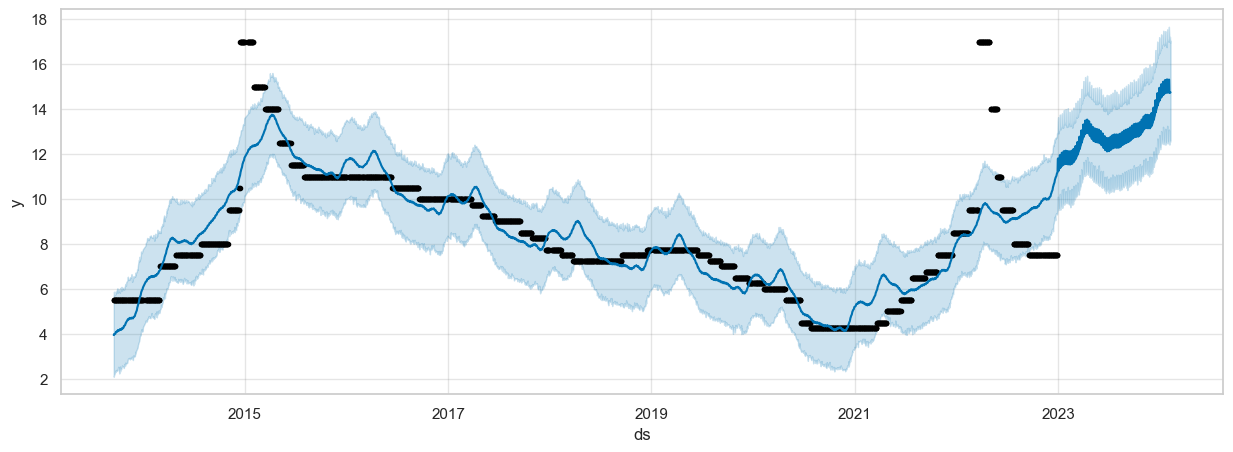

In [126]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will ret

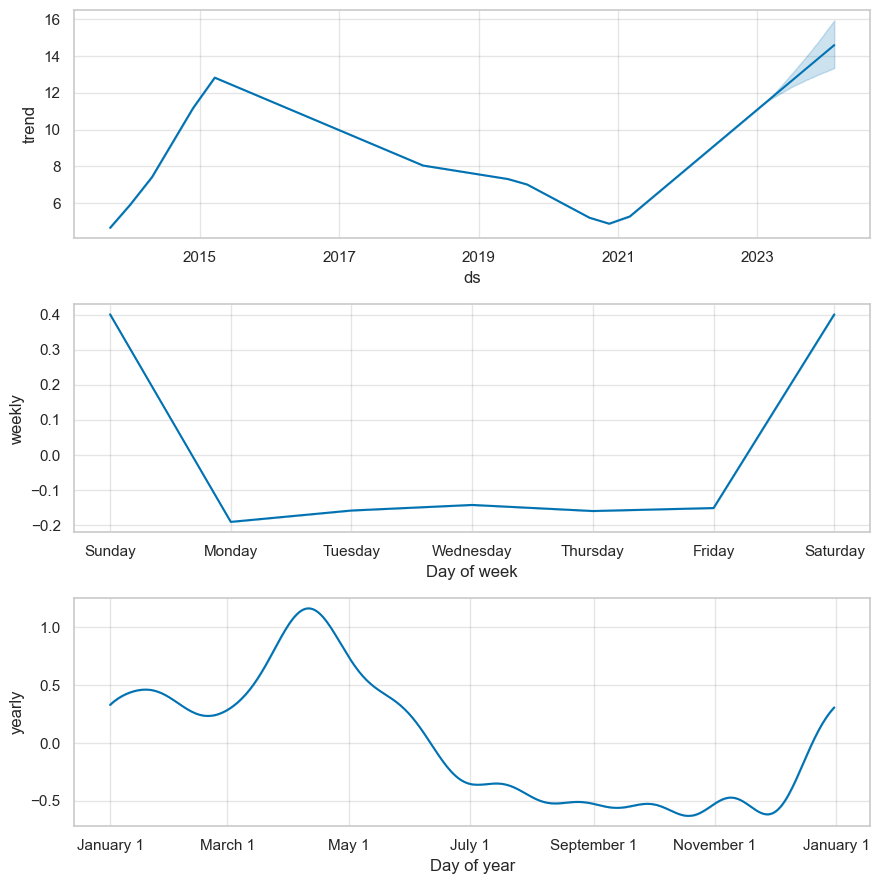

In [127]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [128]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
402,2024-08-02,15.487790,12.684488,18.495992
403,2024-08-05,15.452154,12.581310,18.265722
404,2024-08-06,15.487457,12.547418,18.348100
405,2024-08-07,15.507076,12.633509,18.621613
406,2024-08-08,15.494407,12.524626,18.582844


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




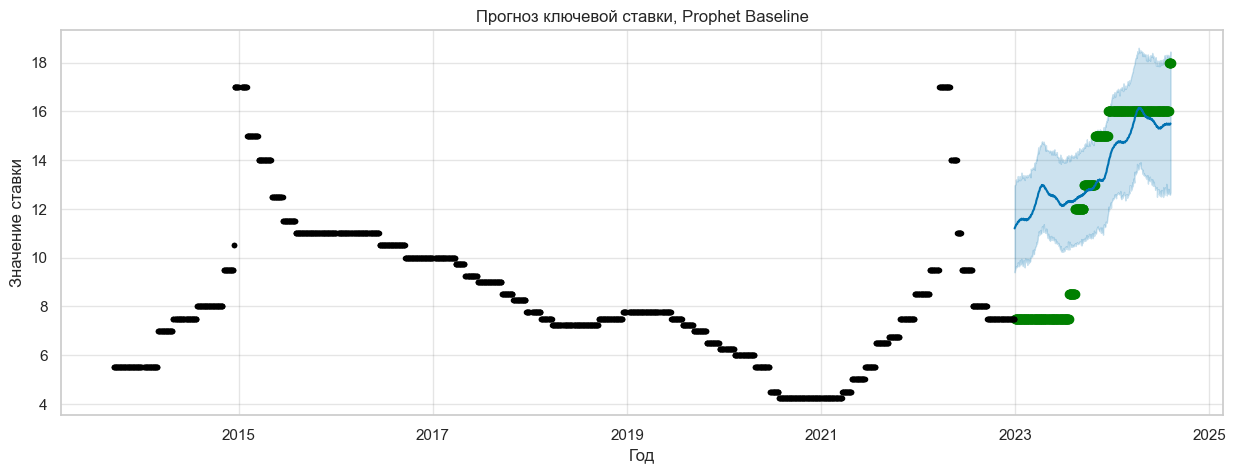

In [129]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

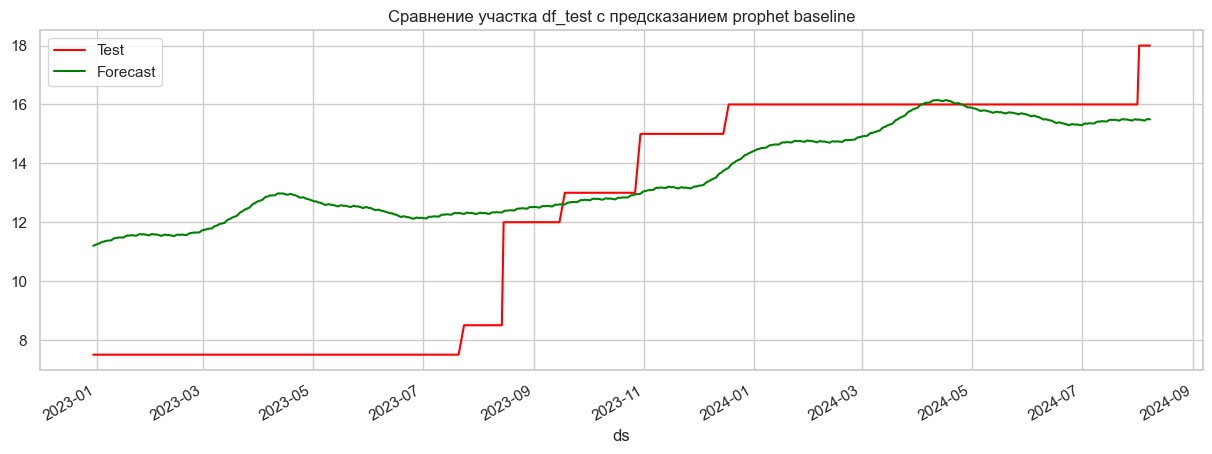

In [130]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [131]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.268207,0.265045,8.836049,2.972549


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [132]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

WARNING - (py.warnings._showwarnmsg) - C:\Users\myxa-\AppData\Local\Temp\ipykernel_6068\3236026523.py:7: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead




In [133]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:33:27 - cmdstanpy - INFO - Chain [1] start processing
02:33:27 - cmdstanpy - INFO - Chain [1] done processing


In [134]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2712,2024-02-05,14.612283,12.395071,16.879947
2713,2024-02-06,14.641249,12.409588,16.717911
2714,2024-02-07,14.656370,12.629122,16.788417
2715,2024-02-08,14.635116,12.446183,16.784192
2716,2024-02-09,14.643221,12.526296,16.841138


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




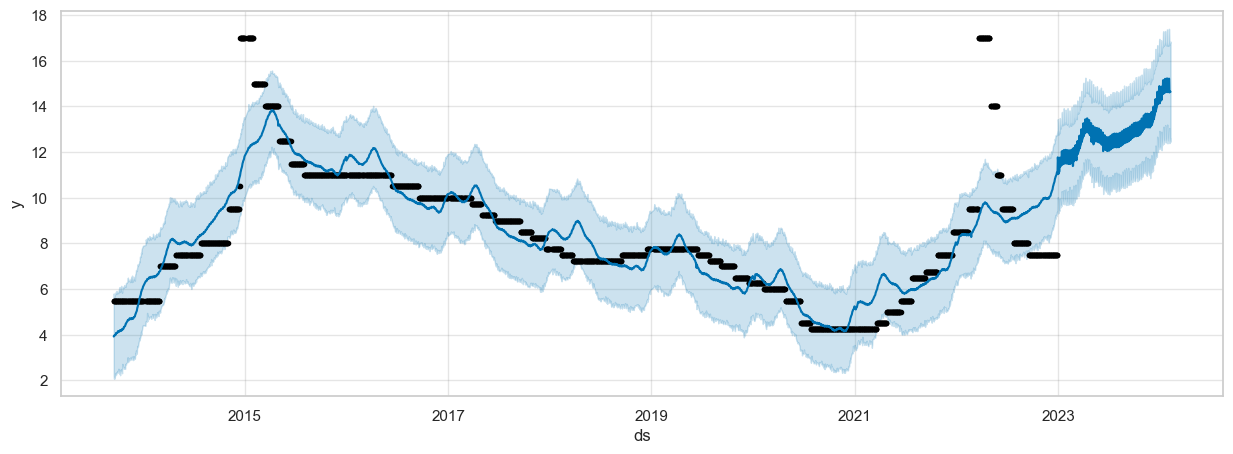

In [135]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will ret

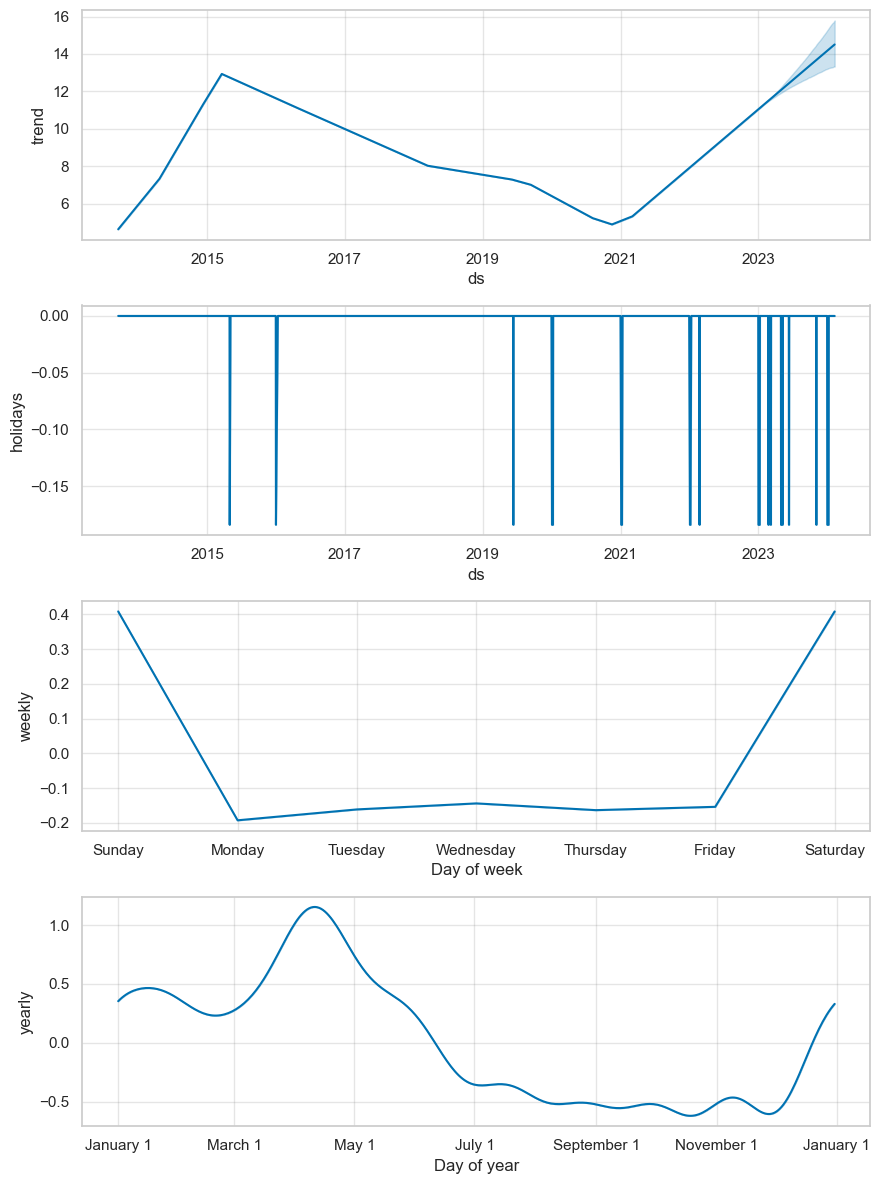

In [136]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [137]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
402,2024-08-02,15.373060,12.722823,18.096128
403,2024-08-05,15.338462,12.670584,18.174838
404,2024-08-06,15.372771,12.634620,18.498675
405,2024-08-07,15.393882,12.620676,18.223685
406,2024-08-08,15.379176,12.258788,18.198387


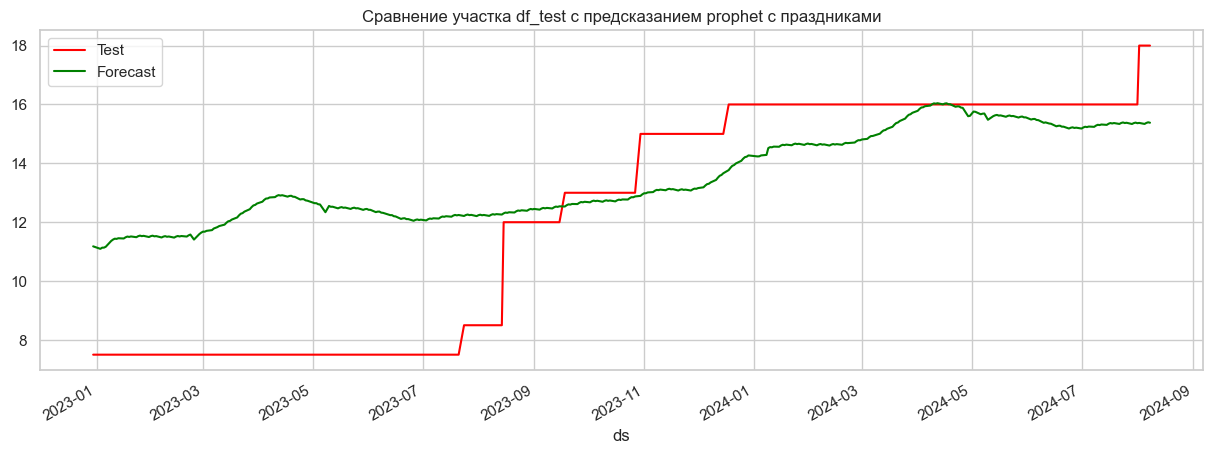

In [138]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [139]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.268207,0.265045,8.836049,2.972549
0,Prophet_with_holidays,2.288603,0.264576,8.700071,2.949588


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [140]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [141]:
"""Обучение тестовой модели по сетке параметров на df_train"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    
    # Обучаем Prophet по сетке гиперпараметров
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


02:33:30 - cmdstanpy - INFO - Chain [1] start processing
02:33:30 - cmdstanpy - INFO - Chain [1] done processing
02:33:30 - cmdstanpy - INFO - Chain [1] start processing
02:33:30 - cmdstanpy - INFO - Chain [1] done processing
02:33:31 - cmdstanpy - INFO - Chain [1] start processing
02:33:31 - cmdstanpy - INFO - Chain [1] done processing
02:33:32 - cmdstanpy - INFO - Chain [1] start processing
02:33:32 - cmdstanpy - INFO - Chain [1] done processing
02:33:32 - cmdstanpy - INFO - Chain [1] start processing
02:33:32 - cmdstanpy - INFO - Chain [1] done processing
02:33:33 - cmdstanpy - INFO - Chain [1] start processing
02:33:33 - cmdstanpy - INFO - Chain [1] done processing
02:33:33 - cmdstanpy - INFO - Chain [1] start processing
02:33:34 - cmdstanpy - INFO - Chain [1] done processing
02:33:34 - cmdstanpy - INFO - Chain [1] start processing
02:33:34 - cmdstanpy - INFO - Chain [1] done processing
02:33:34 - cmdstanpy - INFO - Chain [1] start processing
02:33:35 - cmdstanpy - INFO - Chain [1]

In [142]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [143]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.430974,0.365328,46.565369,6.823882,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.681961,0.384275,50.496494,7.106089,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.651410,0.381835,50.057510,7.075133,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.906014,0.406814,52.542254,7.248604,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.292708,0.354078,44.801602,6.693400,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,16.095407,1.463219,572.298536,23.922762,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,3.098063,0.324377,12.354299,3.514868,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,3.141501,0.333257,13.111042,3.620917,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,3.114666,0.322151,12.232652,3.497521,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [144]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.041201,0.316731,11.752894,3.428249,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,Prophet_with_grid,3.041201,0.316731,11.752894,3.428249,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,Prophet_with_grid,3.041201,0.316731,11.752894,3.428249,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,Prophet_with_grid,3.041201,0.316731,11.752894,3.428249,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,Prophet_with_grid,3.046277,0.315664,11.665365,3.415460,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [145]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [146]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

02:46:04 - cmdstanpy - INFO - Chain [1] start processing
02:46:05 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2712,2024-02-05,14.713849,12.567930,16.929792
2713,2024-02-06,14.743233,12.575240,16.989958
2714,2024-02-07,14.756209,12.435194,16.941085
2715,2024-02-08,14.736290,12.517610,16.912359
2716,2024-02-09,14.742578,12.496161,17.019545


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will ret

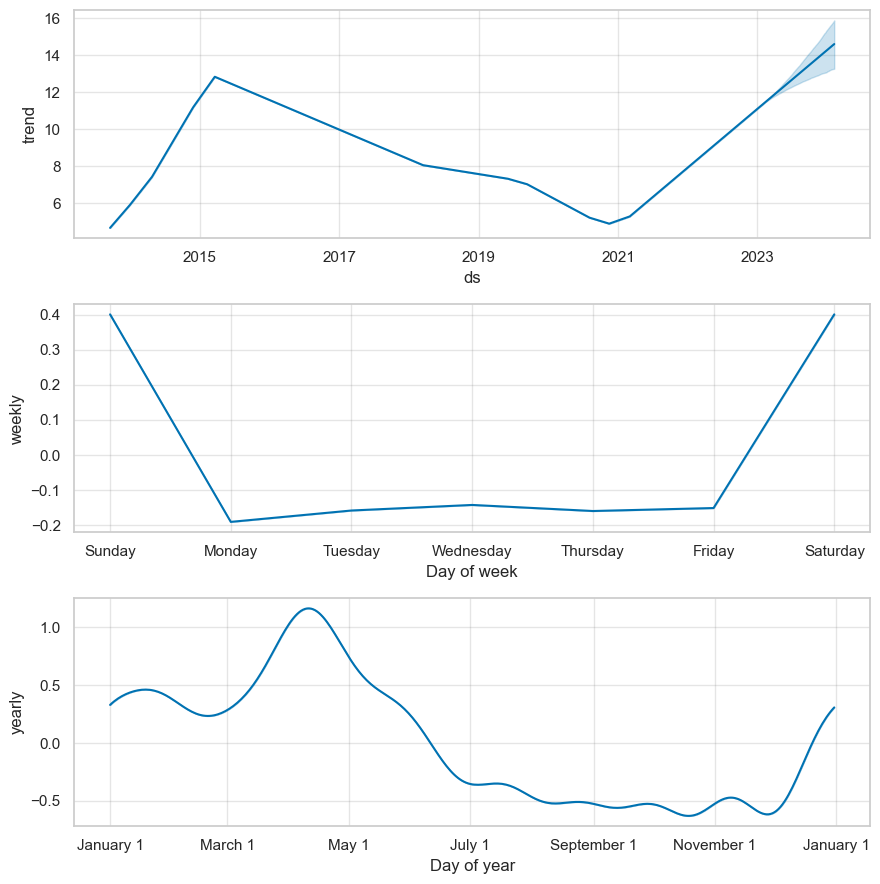

In [148]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




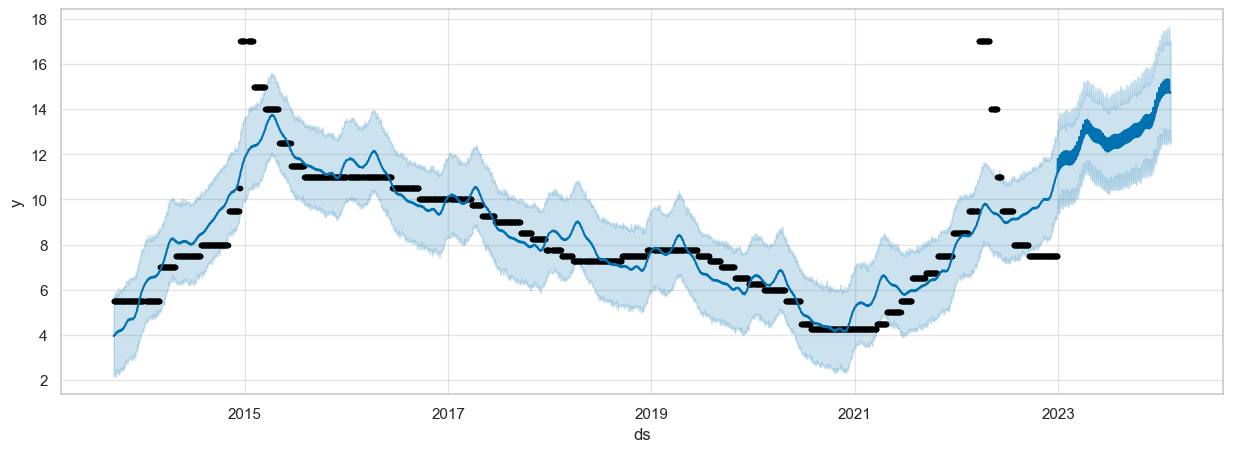

In [149]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [150]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
402,2024-08-02,15.487790,12.553630,18.313255
403,2024-08-05,15.452154,12.565129,18.193676
404,2024-08-06,15.487457,12.545789,18.156496
405,2024-08-07,15.507076,12.807833,18.378187
406,2024-08-08,15.494407,12.641098,18.074730


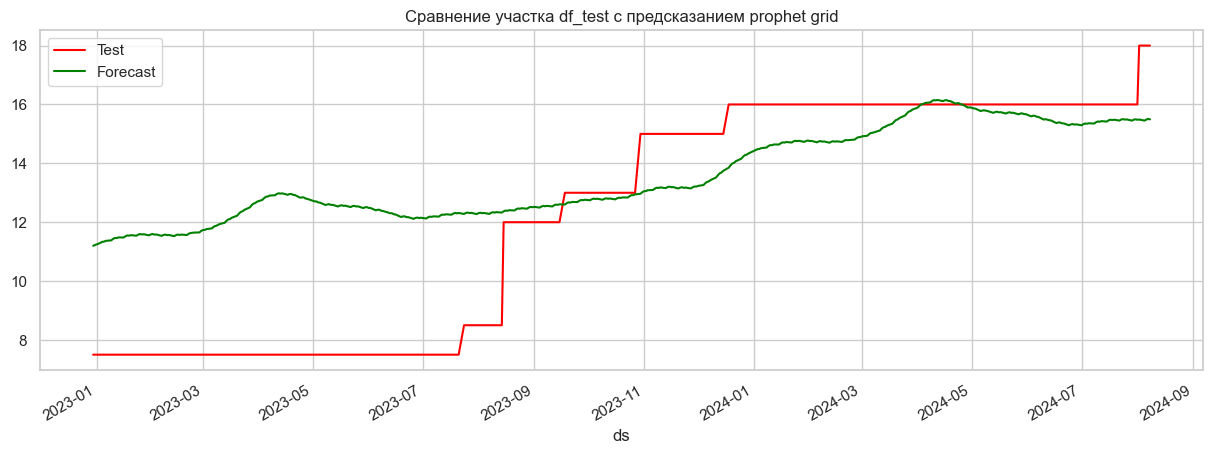

In [151]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [152]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.268207,0.265045,8.836049,2.972549
0,Prophet_with_holidays,2.288603,0.264576,8.700071,2.949588
0,Prophet_with_grid,2.268207,0.265045,8.836049,2.972549


In [153]:
# Сохранение модели в JSON файл
with open('../models/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [154]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.229% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (37) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.
Finding best initial lr: 100%|██████████| 234/234 [00:01<00:00, 123.12it/s]


Training: |          | 0/? [00:27<?, ?it/s, v_num=21, train_loss=0.0217, reg_loss=0.000, MAE=0.759, RMSE=1.340, Loss=0.0212, RegLoss=0.000]


In [155]:
# Создание df с прогнозом
future_np_bl = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = True)
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.229% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Defined frequency

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
402,2024-08-02,18.0,13.326173,16.031303,-0.231168,-2.473963
403,2024-08-05,18.0,13.306067,16.050444,-0.244091,-2.500286
404,2024-08-06,18.0,13.290923,16.056822,-0.248166,-2.517733
405,2024-08-07,18.0,13.329076,16.063206,-0.252150,-2.481979
406,2024-08-08,18.0,13.336747,16.069584,-0.256037,-2.476799


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:300: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




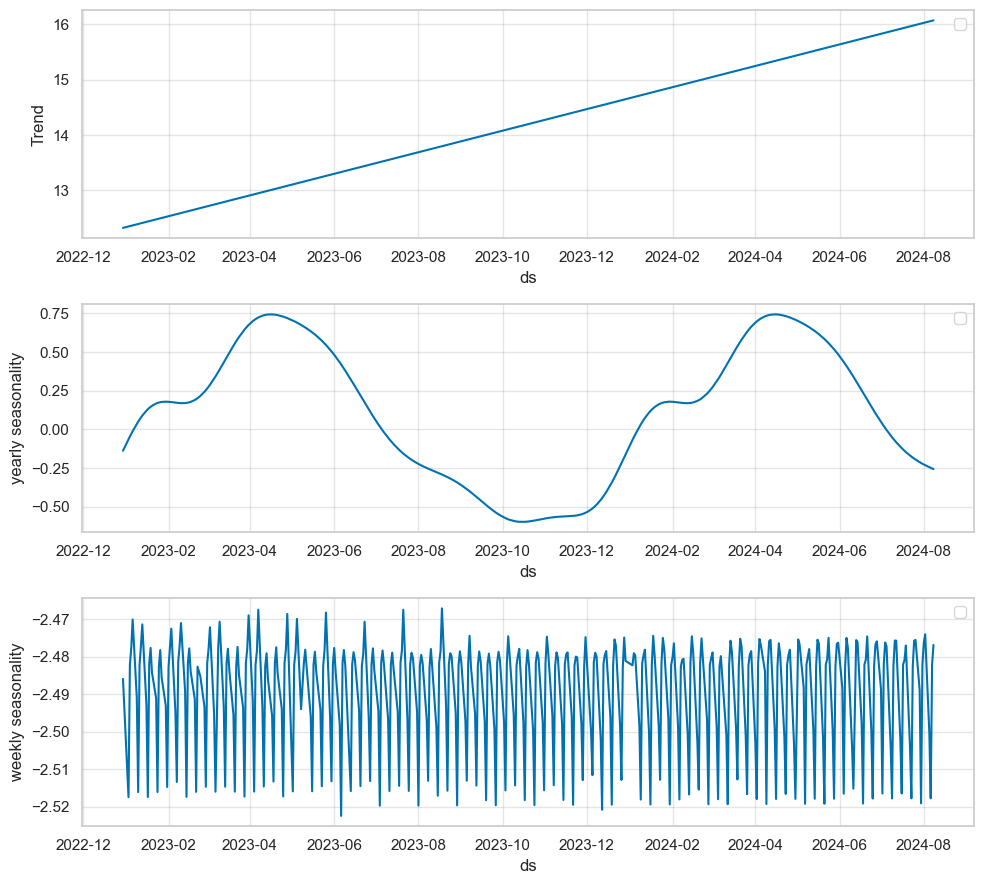

In [165]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl, plotting_backend="matplotlib")

In [167]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax, plotting_backend="matplotlib")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




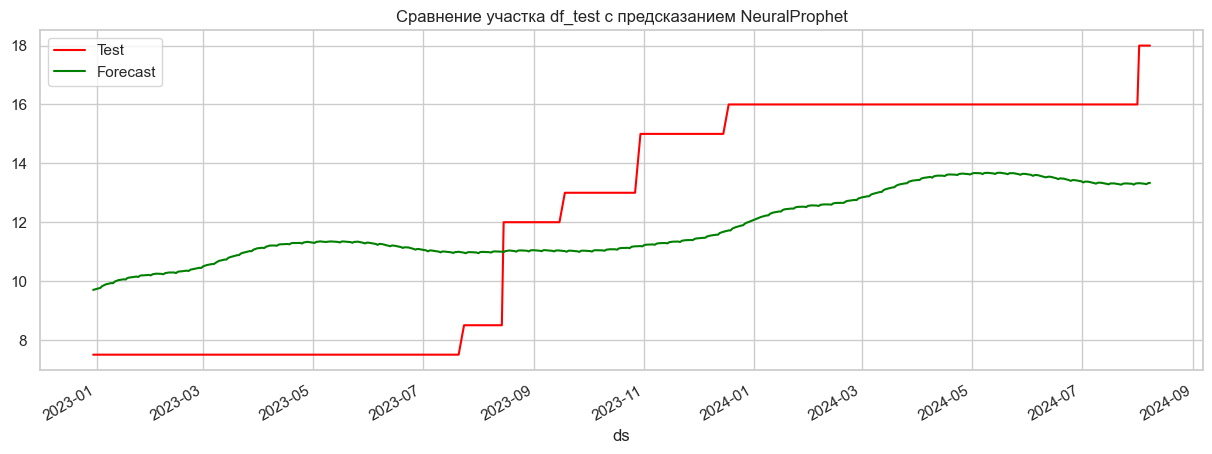

In [168]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [169]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.268207,0.265045,8.836049,2.972549
0,Prophet_with_holidays,2.288603,0.264576,8.700071,2.949588
0,Prophet_with_grid,2.268207,0.265045,8.836049,2.972549
0,NeuralProphet,2.933186,0.274135,9.243891,3.040377


# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных

# Prophet baseline on df

In [170]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

02:53:42 - cmdstanpy - INFO - Chain [1] start processing
02:53:43 - cmdstanpy - INFO - Chain [1] done processing


In [171]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2892,2025-01-31,17.177793,14.921555,19.319078
2893,2025-02-01,18.044294,15.900923,20.069259
2894,2025-02-02,18.041550,15.970464,20.415670
2895,2025-02-03,17.158938,14.863024,19.162069
2896,2025-02-04,17.180408,14.796818,19.099992


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




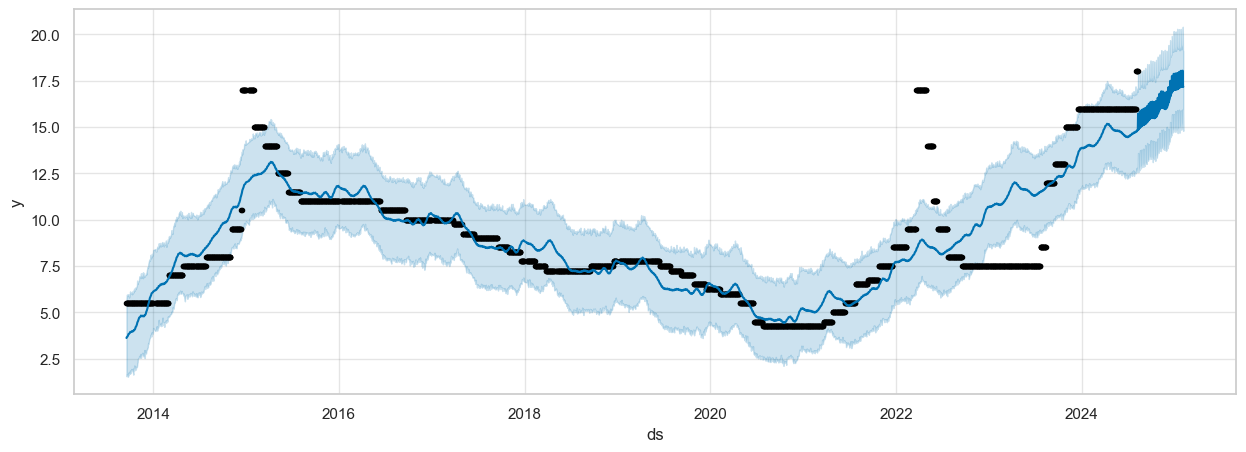

In [172]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will ret

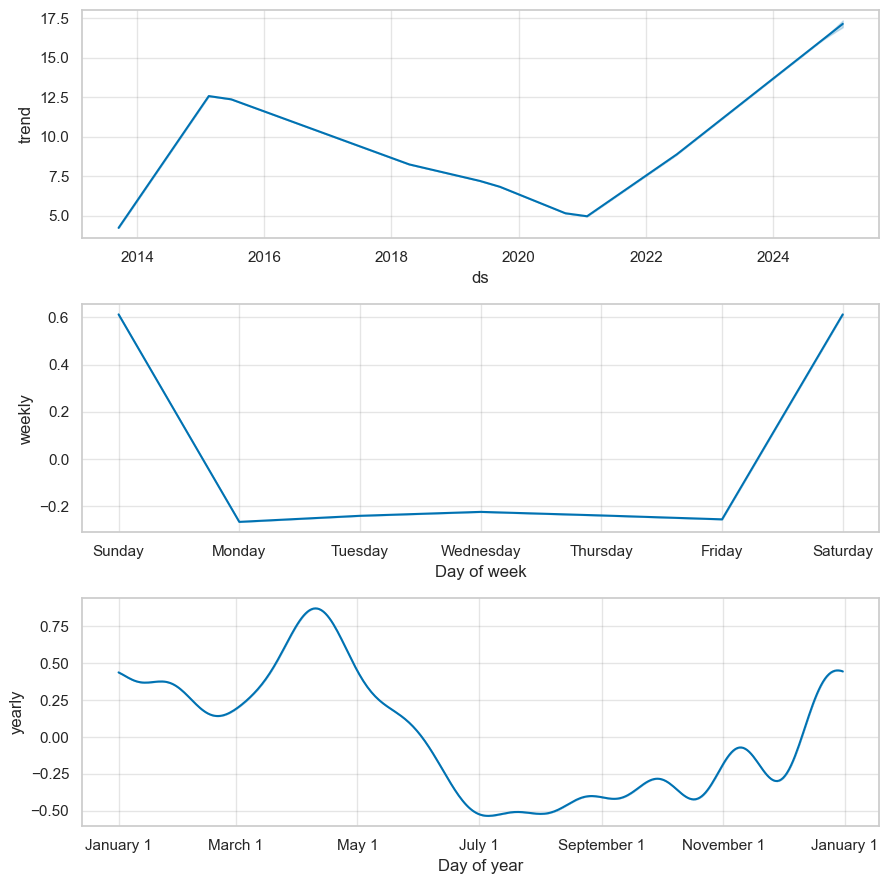

In [173]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [174]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

02:53:45 - cmdstanpy - INFO - Chain [1] start processing
02:53:45 - cmdstanpy - INFO - Chain [1] done processing


In [175]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2892,2025-01-31,17.177793,15.149286,19.316339
2893,2025-02-01,18.044294,15.973949,20.125903
2894,2025-02-02,18.041550,15.894258,20.122566
2895,2025-02-03,17.158938,15.037432,19.377303
2896,2025-02-04,17.180408,14.981659,19.305679


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




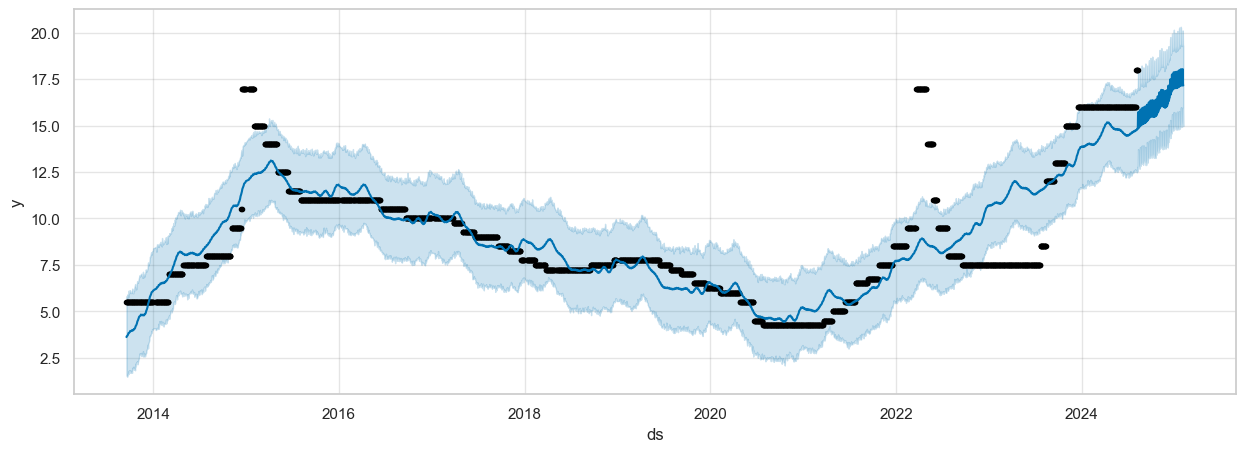

In [176]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will ret

Epoch 90: 100%|██████████| 90/90 [32:54<00:00,  0.05it/s]   


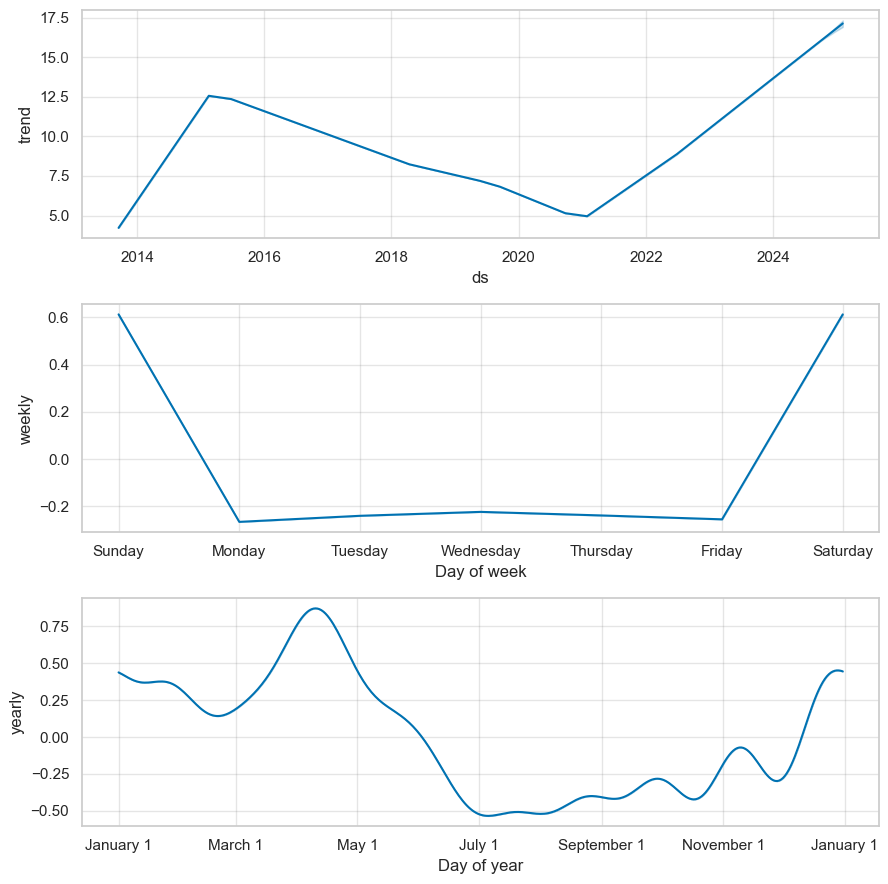

In [177]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# NeuralProphet on df

In [178]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df,)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.203% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (43) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:78: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 29. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Finding best initial lr: 100%|██████████| 236/236 [00:01<00:00, 121.49it/s]


Training: |          | 0/? [00:27<?, ?it/s, v_num=22, train_loss=0.0263, reg_loss=0.000, MAE=0.960, RMSE=1.660, Loss=0.0262, RegLoss=0.000]


In [179]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast-104, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(future_np)
forecast_np.tail()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.203% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Defined frequency

Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 198.13it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2788,2024-11-18,NaN,16.156536,19.266857,-0.048239,-3.062084
2789,2024-11-19,NaN,16.173641,19.275667,-0.046884,-3.055144
2790,2024-11-20,NaN,16.235489,19.284485,-0.045541,-3.003454
2791,2024-11-21,NaN,16.222107,19.293301,-0.044187,-3.027005
2792,2024-11-22,NaN,16.204290,19.302116,-0.042759,-3.055066


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:300: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




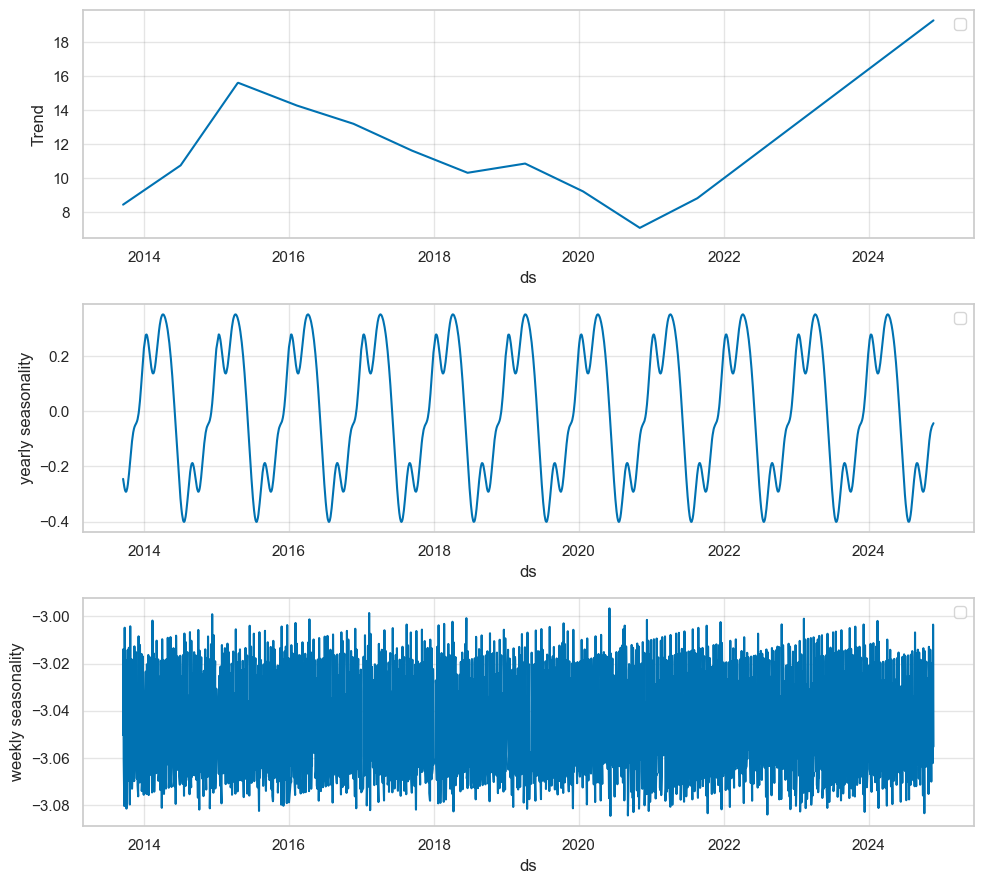

In [181]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np, plotting_backend="matplotlib")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




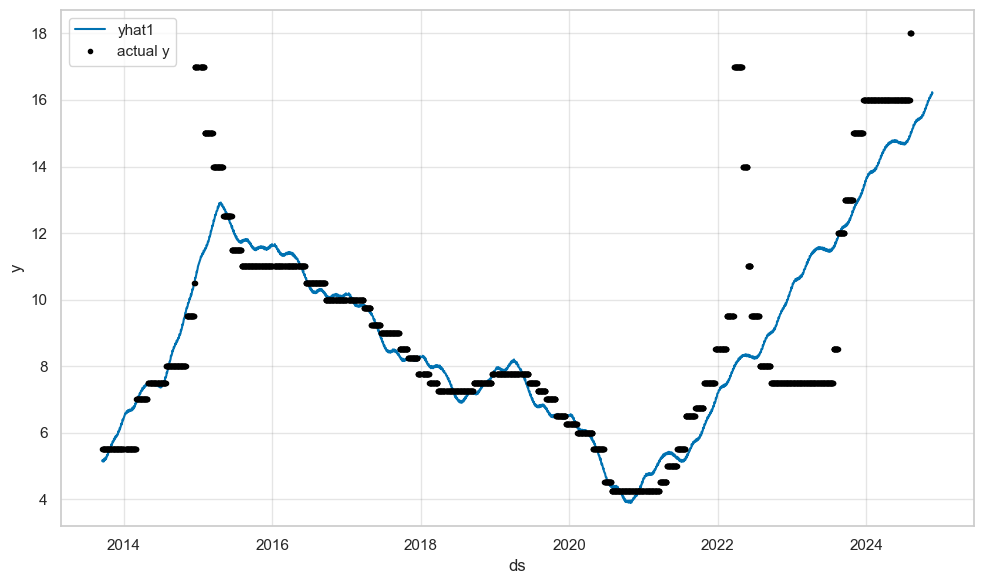

In [183]:
# Смотрим график прогноза
NeuralProphet_df.plot(forecast_np, plotting_backend="matplotlib")

# Сравнение прогнозов обученных моделей

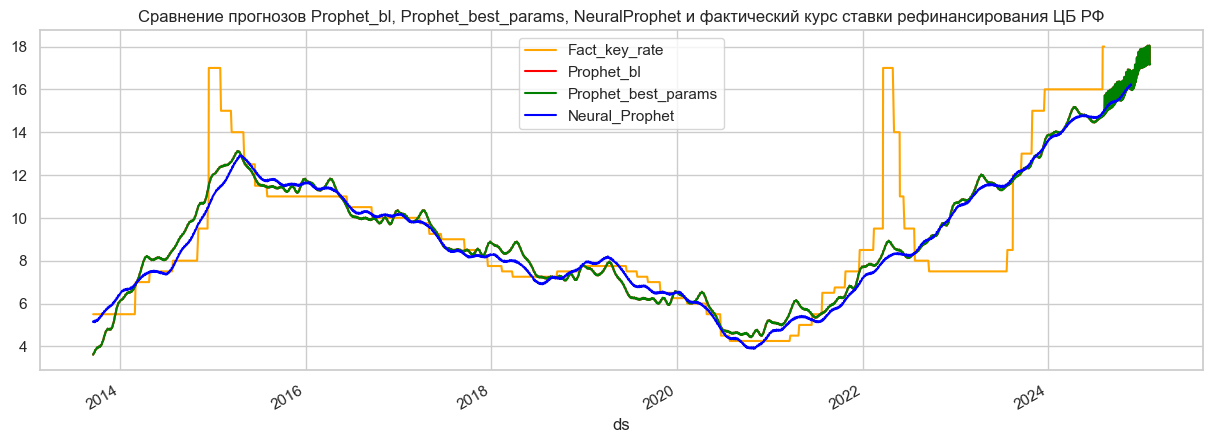

In [184]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
forecast_np.plot(kind='line', x='ds', y='yhat1', color='blue', label='Neural_Prophet', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.